### This notebook is optionally accelerated with a GPU runtime.
### If you would like to use this acceleration, please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# FCN

*Author: Pytorch Team*

**Fully-Convolutional Network model with ResNet-50 and ResNet-101 backbones**

_ | _
- | -
![alt](https://pytorch.org/assets/images/deeplab1.png) | ![alt](https://pytorch.org/assets/images/fcn2.png)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True)
# or
# model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet101', pretrained=True)

from torch.utils.data import DataLoader
from generate_training_validation_data import CustomImageDataset
import numpy as np
import matplotlib.pyplot as plt

train_data_dir = 'D:/MemeMachine_ProjectData/dataset/training'
validation_data_dir = 'D:/MemeMachine_ProjectData/dataset/validation'
img_width, img_height, n_channels = 257, 257, 3 #TODO change dimensions to be wider, to better support text

epochs = 1 #50 TODO
batch_size = 1
# classes = ['nothing', 'text']
classes = ['text']


#change the number of classes in the final step of the classifier
# print(model.classifier[4])
model.classifier[4] = torch.nn.Conv2d(512, len(classes), kernel_size=(1,1), stride = (1,1))
torch.nn.init.xavier_uniform(model.classifier[4].weight)

# print(model.aux_classifier[4])
model.aux_classifier[4] = torch.nn.Conv2d(256, len(classes), kernel_size=(1,1), stride = (1,1))
torch.nn.init.xavier_uniform(model.aux_classifier[4].weight)

model.eval()


Using cache found in C:\Users\maxan/.cache\torch\hub\pytorch_vision_v0.10.0


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

All pre-trained models expect input images normalized in the same way,
i.e. mini-batches of 3-channel RGB images of shape `(N, 3, H, W)`, where `N` is the number of images, `H` and `W` are expected to be at least `224` pixels.
The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]`
and `std = [0.229, 0.224, 0.225]`.

The model returns an `OrderedDict` with two Tensors that are of the same height and width as the input Tensor, but with 21 classes.
`output['out']` contains the semantic masks, and `output['aux']` contains the auxillary loss values per-pixel. In inference mode, `output['aux']` is not useful.
So, `output['out']` is of shape `(N, 21, H, W)`. More documentation can be found [here](https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection).

Feature batch shape: torch.Size([1, 3, 257, 257])
Labels batch shape: torch.Size([1, 66049])


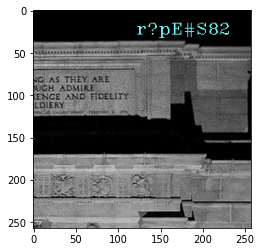

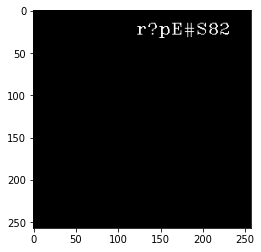

In [2]:
# Select an image from the dataset

#TODO change image_with_text_functions.generate_text_on_image_and_pixel_mask_from_path to place the text properly
train_dataset = CustomImageDataset(train_data_dir, img_width, img_height)
test_dataset = CustomImageDataset(validation_data_dir, img_width, img_height)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, )
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
input_image = train_features[0].squeeze()
input_image = np.moveaxis(input_image.numpy(), 0, -1)
label = train_labels[0].reshape((img_width, img_height))

plt.imshow(input_image, cmap="gray")
plt.show()
plt.imshow(label, cmap="gray")
plt.show()

In [3]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
import cv2 as cv
# input_image = Image.open(filename)
input_image2 = cv.cvtColor(input_image, cv.COLOR_BGR2RGB)
input_image2 = Image.fromarray(np.uint8(input_image2))
input_image2 = input_image2.convert("RGB")

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')
print(input_batch.shape)
with torch.no_grad():
    output = model(input_batch)['out'][0] #zero refers to the batch number?
output_predictions = output.argmax(0)
# print(output_predictions)
# print(output_predictions.shape)
# print(output)
# print(output.shape)


torch.Size([1, 3, 257, 257])


The output here is of shape `(21, H, W)`, and at each location, there are unnormalized probabilities corresponding to the prediction of each class.
To get the maximum prediction of each class, and then use it for a downstream task, you can do `output_predictions = output.argmax(0)`.

Here's a small snippet that plots the predictions, with each color being assigned to each class (see the visualized image on the left).

In [ ]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image2.size)
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.imshow(r)
# plt.show()

### Model Description

FCN-ResNet is constructed by a Fully-Convolutional Network model, using a ResNet-50 or a ResNet-101 backbone.
The pre-trained models have been trained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.

Their accuracies of the pre-trained models evaluated on COCO val2017 dataset are listed below.

| Model structure |   Mean IOU  | Global Pixelwise Accuracy |
| --------------- | ----------- | --------------------------|
|  fcn_resnet50   |   60.5      |   91.4                    |
|  fcn_resnet101  |   63.7      |   91.9                    |

### Resources

 - [Fully Convolutional Networks for Semantic Segmentation](https://arxiv.org/abs/1605.06211)

In [ ]:
from collections import namedtuple
from typing import Any

import torch


# pylint: disable = abstract-method
class ModelWrapper(torch.nn.Module):
    """
    Wrapper class for model with dict/list rvalues.
    """

    def __init__(self, model: torch.nn.Module) -> None:
        """
        Init call.
        """
        super().__init__()
        self.model = model

    def forward(self, input_x: torch.Tensor) -> Any:
        """
        Wrap forward call.
        """
        data = self.model(input_x)

        if isinstance(data, dict):
            data_named_tuple = namedtuple("ModelEndpoints", sorted(data.keys()))  # type: ignore
            data = data_named_tuple(**data)  # type: ignore

        elif isinstance(data, list):
            data = tuple(data)

        return data

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/FCN_resnet101_GPU_text_pixel_masking/lower_learning_rate4/')

# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img,):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# show images
matplotlib_imshow(img_grid)
label_image = np.reshape(np.squeeze(labels), (img_width, img_height))
plt.imshow(label_image)

# write to tensorboard
writer.add_image('FCN_resnet101_GPU_text_pixel_masking_images', img_grid)

model_wrapper = ModelWrapper(model)
writer.add_graph(model_wrapper, torch.tensor(images).to('cuda'))
writer.close()


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")




    probs = net(images)['out']
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(6, 2))

    fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
    # plot the semantic segmentation predictions of 21 classes in each color
    r = Image.fromarray(probs.squeeze().byte().cpu().numpy()).resize((img_width, img_height))
    r.putpalette(colors)
    plt.imshow(r)

    fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
    input_image = images.squeeze().detach().cpu()
    input_image = np.moveaxis(input_image.numpy(), 0, -1)
    plt.imshow(input_image, cmap="gray")

    fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
    label = labels.reshape((img_width, img_height)).detach().cpu()
    plt.imshow(label, cmap="gray")
    return fig

In [ ]:
import torch.optim as optim
import torch.nn as nn

# criterion = nn.CrossEntropyLoss(reduction='sum')
criterion = nn.SoftMarginLoss(size_average=False, reduction='sum')
optimizer = optim.SGD(model.parameters(), lr=10**-40, momentum=0.99) #TODO change learning rate to a lower number
model.train()

In [ ]:

model.train()

# Train the model
mini_epoch_loss = 0.0
epoch_loss = 0.0
for epoch in range(100):  # loop over the dataset multiple times  

    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # print(inputs.shape)

        inputs = inputs.squeeze()
        inputs = np.moveaxis(inputs.detach().cpu().numpy(), 0, -1)
        # print(inputs.shape)
        preprocessed_inputs = cv.cvtColor(inputs, cv.COLOR_BGR2RGB)
        preprocessed_inputs = Image.fromarray(np.uint8(preprocessed_inputs))
        preprocessed_inputs = preprocessed_inputs.convert("RGB")
        preprocessed_inputs = preprocess(preprocessed_inputs)
        preprocessed_inputs = preprocessed_inputs.unsqueeze(0)
        inputs = preprocessed_inputs

        # move the input and model to GPU for speed if available
        if torch.cuda.is_available():
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')
            model.to('cuda')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(inputs)['out'][0]
        # print(output.shape)
        output = output[0]
        # print(output.shape)
        output = torch.unsqueeze(output, 0)
        output = torch.unsqueeze(output, 0)
        # print(output.shape)

        # output_predictions = output.argmax(0)
        # print(labels.shape)
        labels = torch.reshape(labels, (1,257,257))
        labels = labels.long()
        # print(labels.shape)

        # print("labels", labels)
        # print("output", output)


        loss = criterion(output, labels)
        # print("loss", loss)
        loss.backward()
        optimizer.step()

        # print statistics
        epoch_loss += loss.item()
        mini_epoch_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
        # if i % 100 == 1:    # print every 100 mini-batches
        # if i % 2 == 1:    # print every 2 mini-batches


            writer.add_scalar('total epoch loss',
                            epoch_loss,
                            epoch * len(train_dataloader) + i)
            writer.add_scalar('average epoch loss',
                            epoch_loss / 
                            (epoch * len(train_dataloader) + i),
                            epoch * len(train_dataloader) + i)

            writer.add_scalar('total mini-epoch loss',
                mini_epoch_loss,
                epoch * len(train_dataloader) + i)
                
            writer.add_scalar('average mini-epoch loss',
                mini_epoch_loss / 2000,
                epoch * len(train_dataloader) + i)

            mini_epoch_loss = 0.0
            writer.add_scalar('most recent cost',
                            loss.item(),
                            epoch * len(train_dataloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(model, inputs, labels),
                            global_step=epoch * len(train_dataloader) + i)
 
print('Finished Training')

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Show a test of the newly trained (fine tuned) model below

In [ ]:
model.eval()

# Display image and label.
test_features, test_labels = next(iter(test_dataloader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")
input_image = test_features[0].squeeze()
input_image = np.moveaxis(input_image.numpy(), 0, -1)
label = test_labels[0].reshape((img_width, img_height))

plt.imshow(input_image, cmap="gray")
plt.show()
plt.imshow(label, cmap="gray")
plt.show()

In [ ]:
# input_image = Image.open(filename)
input_image2 = cv.cvtColor(input_image, cv.COLOR_BGR2RGB)
input_image2 = Image.fromarray(np.uint8(input_image2))
input_image2 = input_image2.convert("RGB")

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0] #zero refers to the batch number?
output_predictions = output.argmax(0)
print(output_predictions)
print(output_predictions.shape)
print(output)
print(output.shape)

In [ ]:
test(test_dataloader, model, criterion)